# Анализ экономического развития стран и его связи с другими показателями 

## Содержание:
1. [Выгрузка данных с сайта Всемирного банка спомощью API](#soderjanie_1)
2. [Очистка и предобработка данных](#soderjanie_2)
3. [Создание соединения к базе данных](#soderjanie_3)
4. [Анализ данных](#soderjanie_4)


## 1. Выгрузка данных с сайта Всемирного банка спомощью API<a id='soderjanie_1'></a>

In [864]:
!pip install phik

In [865]:
#Импортируем библиотеки
import requests
import json
import pandas as pd
from typing import List, Optional
import sqlite3

#Загрузим библиотеку для визуализации пропусков
!pip install missingno -q
import missingno as msno

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

___

Получаем данные о странах

In [866]:
# Cохраняем API всемирного банка с информацией о странах 
url = "https://api.worldbank.org/v2/country?format=json&per_page=500"  

In [867]:
try:
    # Отправляем GET запрос к World Bank API
    response = requests.get(url)
    response.raise_for_status()  
    # Поднимает ошибку (4** или 5**) если статус некорректный

    # Десериализуем полученный JSON-ответ. 
    # Парсим ответ от API в вид JSON
    data = response.json()

# Обрабатываем ошибки, если такие возникнут
except requests.exceptions.RequestException as e:
    print(f"An error occurred while fetching data: {e}")
except (IndexError, KeyError, ValueError) as e:
    print(f"An error occurred while processing the data: {e}")


In [868]:
print(data)

[{'page': 1, 'pages': 1, 'per_page': '500', 'total': 296}, [{'id': 'ABW', 'iso2Code': 'AW', 'name': 'Aruba', 'region': {'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Latin America & Caribbean '}, 'adminregion': {'id': '', 'iso2code': '', 'value': ''}, 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'}, 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'}, 'capitalCity': 'Oranjestad', 'longitude': '-70.0167', 'latitude': '12.5167'}, {'id': 'AFE', 'iso2Code': 'ZH', 'name': 'Africa Eastern and Southern', 'region': {'id': 'NA', 'iso2code': 'NA', 'value': 'Aggregates'}, 'adminregion': {'id': '', 'iso2code': '', 'value': ''}, 'incomeLevel': {'id': 'NA', 'iso2code': 'NA', 'value': 'Aggregates'}, 'lendingType': {'id': '', 'iso2code': '', 'value': 'Aggregates'}, 'capitalCity': '', 'longitude': '', 'latitude': ''}, {'id': 'AFG', 'iso2Code': 'AF', 'name': 'Afghanistan', 'region': {'id': 'MEA', 'iso2code': 'ZQ', 'value': 'Middle East, North Africa, Afghanistan &

In [869]:
#Первый элемент ответа
data[0]

{'page': 1, 'pages': 1, 'per_page': '500', 'total': 296}

In [870]:
data[1][0]

{'id': 'ABW',
 'iso2Code': 'AW',
 'name': 'Aruba',
 'region': {'id': 'LCN',
  'iso2code': 'ZJ',
  'value': 'Latin America & Caribbean '},
 'adminregion': {'id': '', 'iso2code': '', 'value': ''},
 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'},
 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'},
 'capitalCity': 'Oranjestad',
 'longitude': '-70.0167',
 'latitude': '12.5167'}

In [871]:
#Выделяем второй элемент в переменную страны
countries = data[1]

In [872]:
#Создаем из полученных данных датафрейм
df_countries = pd.DataFrame(countries)

In [873]:
df_countries.head()

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,"{'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Lati...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'HIC', 'iso2code': 'XD', 'value': 'High...","{'id': 'LNX', 'iso2code': 'XX', 'value': 'Not ...",Oranjestad,-70.0167,12.5167
1,AFE,ZH,Africa Eastern and Southern,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
2,AFG,AF,Afghanistan,"{'id': 'MEA', 'iso2code': 'ZQ', 'value': 'Midd...","{'id': 'MNA', 'iso2code': 'XQ', 'value': 'Midd...","{'id': 'LIC', 'iso2code': 'XM', 'value': 'Low ...","{'id': 'IDX', 'iso2code': 'XI', 'value': 'IDA'}",Kabul,69.1761,34.5228
3,AFR,A9,Africa,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
4,AFW,ZI,Africa Western and Central,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,


In [874]:
#Получим идентификатор региона из столбца регион: для этого вытаскиваем значения по ключу id
df_countries['region_id'] = df_countries.region.apply(lambda x: x.get('id', None))

In [875]:
#Получим информацию о регионах, административных регионах, уровню дохода
#и типу лендинга - вытаскиваем значения по ключу value
for col in ['region', 'adminregion', 'incomeLevel', 'lendingType']:
    df_countries[col + '_value'] = df_countries[col].apply(lambda cell: cell.get('value', None))

In [876]:
#Оставляем только нужные для анализа столбцы
df_countries = df_countries[['id', 'iso2Code', 'name', 'capitalCity', 'longitude', 'latitude',
         'region_id', 'region_value', 'adminregion_value', 'incomeLevel_value',
         'lendingType_value']]

In [877]:
df_countries.head()

,id,iso2Code,name,capitalCity,longitude,latitude,region_id,region_value,adminregion_value,incomeLevel_value,lendingType_value
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,LCN,Latin America & Caribbean,,High income,Not classified
1,AFE,ZH,Africa Eastern and Southern,,,,NA,Aggregates,,Aggregates,Aggregates
2,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,MEA,"Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakis...",Low income,IDA
3,AFR,A9,Africa,,,,NA,Aggregates,,Aggregates,Aggregates
4,AFW,ZI,Africa Western and Central,,,,NA,Aggregates,,Aggregates,Aggregates


In [878]:
#Приводим названия столбцов к snake_case
old_cols = df_countries.columns.tolist()
new_cols = ['id', 'iso2_code', 'name', 'capital', 'longitude', 'latitude',
            'region_id', 'region', 'admin_region', 'income_level', 'lending_type']

change_dict = dict(zip(old_cols, new_cols))

In [879]:
df_countries = df_countries.rename(columns=change_dict)

In [880]:
#Меняем расположение столбцов
df_countries = df_countries[['id', 'iso2_code', 'name', 'region_id', 'region', 'admin_region',
         'income_level', 'capital', 'longitude', 'latitude', 'lending_type']]

In [881]:
df_countries.sample(3)

,id,iso2_code,name,region_id,region,admin_region,income_level,capital,longitude,latitude,lending_type
197,NCL,NC,New Caledonia,EAS,East Asia & Pacific,,High income,Noum'ea,166.464,-22.2677,Not classified
154,LBR,LR,Liberia,SSF,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Low income,Monrovia,-10.7957,6.30039,IDA
170,MAF,MF,St. Martin (French part),LCN,Latin America & Caribbean,,High income,Marigot,,,Not classified


__________________

Получаем список индикаторов

In [882]:
# сохраняем API всемирного банка с информацией о показателях
url1 = "https://api.worldbank.org/v2/indicators?format=json&per_page=30000"

In [883]:
try:
    # Отправляем GET запрос к World Bank API
    response1 = requests.get(url1)
    response1.raise_for_status()  
    # Поднимает ошибку (4** или 5**) если статус некорректный

    # Десериализуем полученный JSON-ответ. 
    # Парсим ответ от API в вид JSON
    data1 = response1.json()

# Обрабатываем ошибки, если такие возникнут
except requests.exceptions.RequestException as e:
    print(f"An error occurred while fetching data: {e}")
except (IndexError, KeyError, ValueError) as e:
    print(f"An error occurred while processing the data: {e}")

In [884]:
print(data1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [885]:
data1[0]

{'page': 1, 'pages': 1, 'per_page': '30000', 'total': 29323}

In [886]:
#Выделяем второй элемент в переменную индикатора
indicators=data1[1]
indicators

[{'id': '1.0.HCount.1.90usd',
  'name': 'Poverty Headcount ($1.90 a day)',
  'unit': '',
  'source': {'id': '37', 'value': 'LAC Equity Lab'},
  'sourceNote': 'The poverty headcount index measures the proportion of the population with daily per capita income (in 2011 PPP) below the poverty line.',
  'sourceOrganization': 'LAC Equity Lab tabulations of SEDLAC (CEDLAS and the World Bank).',
  'topics': [{'id': '11', 'value': 'Poverty '}]},
 {'id': '1.0.HCount.2.5usd',
  'name': 'Poverty Headcount ($2.50 a day)',
  'unit': '',
  'source': {'id': '37', 'value': 'LAC Equity Lab'},
  'sourceNote': 'The poverty headcount index measures the proportion of the population with daily per capita income (in 2005 PPP) below the poverty line.',
  'sourceOrganization': 'LAC Equity Lab tabulations of SEDLAC (CEDLAS and the World Bank).',
  'topics': [{'id': '11', 'value': 'Poverty '}]},
 {'id': '1.0.HCount.Mid10to50',
  'name': 'Middle Class ($10-50 a day) Headcount',
  'unit': '',
  'source': {'id': '37

In [887]:
#Используем метод json_normalize для нормализации JSON при создании датафрейма
df_indicators = pd.json_normalize(indicators)

In [888]:
df_indicators.tail(5)

,id,name,unit,sourceNote,sourceOrganization,topics,source.id,source.value
29307,ytil_some_dfcl_all,Youth idle rate (% of persons with some degree...,,,,[],92,Disability Data Hub (DDH)
29308,ytil_some_dfcl_fem,Youth idle rate (% of female persons with some...,,,,[],92,Disability Data Hub (DDH)
29309,ytil_some_dfcl_male,Youth idle rate (% of male persons with some d...,,,,[],92,Disability Data Hub (DDH)
29310,ytil_some_dfcl_rur,Youth idle rate (% of persons living in rural ...,,,,[],92,Disability Data Hub (DDH)
29311,ytil_some_dfcl_urb,Youth idle rate (% of persons living in urban ...,,,,[{}],92,Disability Data Hub (DDH)


In [889]:
#Приводим названия столбцов к snake_case
old_cols1 = df_indicators.columns.tolist()
new_cols1 = ['id',
 'name',
 'unit',
 'source_note',
 'source_organization',
 'topics',
 'source_id',
 'source_value']
change_dict1 = dict(zip(old_cols1, new_cols1))

In [890]:
df_indicators= df_indicators.rename(columns=change_dict1)

In [891]:
df_indicators=df_indicators[['id',
 'name',
 'unit',
 'source_note',
 'source_organization',
 'source_id',
 'source_value']]

In [892]:
df_indicators.sample(3)

,id,name,unit,source_note,source_organization,source_id,source_value
20275,per_si_allsi.bry_q4_preT_totfr,Beneficiary incidence in 4th quintile (%) - Al...,,,,29,The Atlas of Social Protection: Indicators of ...
5701,DT.DOD.DLTL.CD.OT.AR.TR.US,"Gross Ext. Debt Pos., Other Sectors, Long-term...",,,,22,Quarterly External Debt Statistics SDDS
19463,per_sa_os.ben_q1_rur,Benefits incidence in 1st quintile (poorest) (...,,Percentage of benefits going to the 1st quinti...,ASPIRE,29,The Atlas of Social Protection: Indicators of ...


____


Получаем значения показателей

In [893]:
def worldbank_data(indicators: List[str],
                         start_year: int,
                         end_year: int,
                         language: str = 'en') -> pd.DataFrame:

    '''
    Получает данные показателей из API Всемирного банка.

    Args:
        indicators: Список кодов показателей (например, ['EN.GHG.CO2.IC.MT.CE.AR5'])
        start_year: Год начала периода
        end_year: Год окончания периода
        language: Язык данных ('en', 'ru' и т.д.)

    Returns:
        pandas.DataFrame с данными показателей
    '''

    base_url = "https://api.worldbank.org/v2/country/all/indicator" 
    # endpoint API - адрес по которому мы обращаемся за данными


    # список для хранения данных о показателях
    all_data = []

    try:
        for indicator in indicators:
            # Формируем URL для запроса
            url = f"{base_url}/{indicator}"
            params = {
                'format': 'json',
                'date': f"{start_year}:{end_year}",
                'per_page': 10000  # Большое значение для получения всех данных
            }

            # Выполняем запрос к API
            response = requests.get(url, params=params)
            response.raise_for_status()

            data = response.json()

            # API возвращает массив, где первый элемент - метаданные, второй - данные
            if len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    if item.get('value') is not None:
                        all_data.append({
                            'country': item['country']['value'],
                            'country_code': item['countryiso3code'],
                            'indicator': item['indicator']['value'],
                            'indicator_code': item['indicator']['id'],
                            'year': int(item['date']),
                            'value': item['value']
                        })

        # Создаем DataFrame
        df = pd.DataFrame(all_data)

        if df.empty:
            print("Предупреждение: Не получено данных для указанных параметров")
            return df

        return df

    # Обрабатываем возможные ошибки при работе с АПИ
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к API: {e}")
        return pd.DataFrame()
    except (KeyError, IndexError, ValueError) as e:
        print(f"Ошибка при обработке данных: {e}")
        return pd.DataFrame()

In [894]:
# Получаем данные 
indicators = ['NY.GDP.MKTP.KD.ZG', 'NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD', 'SP.POP.TOTL', 'BX.KLT.DINV.CD.WD', 
              'NY.GDP.DEFL.KD.ZG', 'SE.PRM.ENRL', 'SL.TLF.ADVN.ZS', 'SL.UEM.TOTL.ZS', 'SP.DYN.CBRT.IN',
              'SI.POV.LMIC', 'GC.DOD.TOTL.GD.ZS'] #Показатели
start_year = 1960
end_year = 2024

df_data = worldbank_data(indicators, start_year, end_year)

df_data.sample(10)

,country,country_code,indicator,indicator_code,year,value
45849,Albania,ALB,"Inflation, GDP deflator (annual %)",NY.GDP.DEFL.KD.ZG,1998,7.855155e+00
26802,IBRD only,IBD,"Population, total",SP.POP.TOTL,1986,3.212178e+09
72372,Greece,GRC,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,2023,6.800000e+00
66293,Lower middle income,,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,2022,2.102655e+01
69078,Bosnia and Herzegovina,BIH,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1989,1.572400e+01
25919,Central Europe and the Baltics,CEB,"Population, total",SP.POP.TOTL,2024,1.000501e+08
4003,Bermuda,BMU,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,2005,1.674206e+00
58795,Botswana,BWA,Labor force with advanced education (% of tota...,SL.TLF.ADVN.ZS,2009,8.757100e+01
46809,Benin,BEN,"Inflation, GDP deflator (annual %)",NY.GDP.DEFL.KD.ZG,2016,6.835911e-01
47098,Botswana,BWA,"Inflation, GDP deflator (annual %)",NY.GDP.DEFL.KD.ZG,2006,5.154398e+00


In [895]:
df_data['indicator_code'].value_counts()

SP.POP.TOTL          9935
SP.DYN.CBRT.IN       9782
NY.GDP.MKTP.CD       8639
NY.GDP.PCAP.CD       8639
NY.GDP.MKTP.KD.ZG    8381
NY.GDP.DEFL.KD.ZG    8329
BX.KLT.DINV.CD.WD    7339
SE.PRM.ENRL          6905
SL.UEM.TOTL.ZS       4692
SI.POV.LMIC          1785
SL.TLF.ADVN.ZS       1577
GC.DOD.TOTL.GD.ZS     865
Name: indicator_code, dtype: int64

___


## 2. Очистка и предобработка данных<a id='soderjanie_2'></a>

In [896]:
# Выводим первые строки датафрейма
df_countries.head()

,id,iso2_code,name,region_id,region,admin_region,income_level,capital,longitude,latitude,lending_type
0,ABW,AW,Aruba,LCN,Latin America & Caribbean,,High income,Oranjestad,-70.0167,12.5167,Not classified
1,AFE,ZH,Africa Eastern and Southern,NA,Aggregates,,Aggregates,,,,Aggregates
2,AFG,AF,Afghanistan,MEA,"Middle East, North Africa, Afghanistan & Pakistan","Middle East, North Africa, Afghanistan & Pakis...",Low income,Kabul,69.1761,34.5228,IDA
3,AFR,A9,Africa,NA,Aggregates,,Aggregates,,,,Aggregates
4,AFW,ZI,Africa Western and Central,NA,Aggregates,,Aggregates,,,,Aggregates


In [897]:
# Выводим информацию о датафрейме
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            296 non-null    object
 1   iso2_code     296 non-null    object
 2   name          296 non-null    object
 3   region_id     296 non-null    object
 4   region        296 non-null    object
 5   admin_region  296 non-null    object
 6   income_level  296 non-null    object
 7   capital       296 non-null    object
 8   longitude     296 non-null    object
 9   latitude      296 non-null    object
 10  lending_type  296 non-null    object
dtypes: object(11)
memory usage: 25.6+ KB


In [898]:
# Убираем строки с агрегированными значениями
df_countries=df_countries[df_countries['region']!='Aggregates']

In [899]:
# Выводим количество пропущенных строк в датафрейме
df_countries.isna().sum()

id              0
iso2_code       0
name            0
region_id       0
region          0
admin_region    0
income_level    0
capital         0
longitude       0
latitude        0
lending_type    0
dtype: int64

In [900]:
# Меняем тип данных на числовой
for column in ['longitude','latitude']:
    df_countries[column]=pd.to_numeric(df_countries[column])

In [901]:
# Выводим случайные 5 строк
df_countries.sample(5)

,id,iso2_code,name,region_id,region,admin_region,income_level,capital,longitude,latitude,lending_type
285,VIR,VI,Virgin Islands (U.S.),LCN,Latin America & Caribbean,,High income,Charlotte Amalie,-64.89630,18.33580,Not classified
105,GHA,GH,Ghana,SSF,Sub-Saharan Africa,Sub-Saharan Africa (excluding high income),Lower middle income,Accra,-0.20795,5.57045,IDA
43,CAN,CA,Canada,NAC,North America,,High income,Ottawa,-75.69190,45.42150,Not classified
169,MAC,MO,"Macao SAR, China",EAS,East Asia & Pacific,,High income,,113.55000,22.16670,Not classified
226,PYF,PF,French Polynesia,EAS,East Asia & Pacific,,High income,Papeete,-149.57000,-17.53500,Not classified


In [902]:
# Выводим информацию о датафрейме
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 295
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            217 non-null    object 
 1   iso2_code     217 non-null    object 
 2   name          217 non-null    object 
 3   region_id     217 non-null    object 
 4   region        217 non-null    object 
 5   admin_region  217 non-null    object 
 6   income_level  217 non-null    object 
 7   capital       217 non-null    object 
 8   longitude     211 non-null    float64
 9   latitude      211 non-null    float64
 10  lending_type  217 non-null    object 
dtypes: float64(2), object(9)
memory usage: 20.3+ KB


In [903]:
# Проверяем уникальные значения в категориальных столбцах
for column in ['region_id', 'region', 'income_level']:
    print(f'Уникальные значения в столбце {column}:')
    print(df_countries[column].sort_values().unique())
    print()

Уникальные значения в столбце region_id:
['EAS' 'ECS' 'LCN' 'MEA' 'NAC' 'SAS' 'SSF']

Уникальные значения в столбце region:
['East Asia & Pacific' 'Europe & Central Asia'
 'Latin America & Caribbean '
 'Middle East, North Africa, Afghanistan & Pakistan' 'North America'
 'South Asia' 'Sub-Saharan Africa ']

Уникальные значения в столбце income_level:
['High income' 'Low income' 'Lower middle income' 'Not classified'
 'Upper middle income']



In [904]:
for column in ['region_id', 'region', 'income_level']:
    print(f'Распределение данных по значениям столбца {column}:')
    print(df_countries[column].value_counts())
    print()

Распределение данных по значениям столбца region_id:
ECS    58
SSF    48
LCN    42
EAS    37
MEA    23
SAS     6
NAC     3
Name: region_id, dtype: int64

Распределение данных по значениям столбца region:
Europe & Central Asia                                58
Sub-Saharan Africa                                   48
Latin America & Caribbean                            42
East Asia & Pacific                                  37
Middle East, North Africa, Afghanistan & Pakistan    23
South Asia                                            6
North America                                         3
Name: region, dtype: int64

Распределение данных по значениям столбца income_level:
High income            86
Upper middle income    54
Lower middle income    50
Low income             25
Not classified          2
Name: income_level, dtype: int64



In [905]:
# Проверяем полные дубликаты в датафрейме
df_countries.duplicated().sum()

0

___

In [906]:
# Выводим случайные 5 строк
df_indicators.sample(5)

,id,name,unit,source_note,source_organization,source_id,source_value
10259,fin34b.5,"Received wages: through a mobile phone, primar...",,,,28,Global Findex database
28342,UIS.NERT.3.GPI,"Total net enrolment rate, upper secondary, gen...",,Ratio of female total net enrolment rate for u...,UNESCO Institute for Statistics,12,Education Statistics
24790,SE.XPD.MSEC.ZS,"All education staff compensation, secondary (%...",,All staff (teacher and non-teachers) compensat...,UNESCO Institute for Statistics (http://uis.un...,57,WDI Database Archives
1380,AG.LND.IRIG.HA,"Land use, irrigated land (hectares)",,,,57,WDI Database Archives
7515,DT.TDS.DLTS.CD.GG.1824.US,"Gross Ext. Debt Pmt, General Government, More ...",,,,22,Quarterly External Debt Statistics SDDS


In [907]:
# Выводим информацию о датафрейме
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29312 entries, 0 to 29311
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29312 non-null  object
 1   name                 29312 non-null  object
 2   unit                 29312 non-null  object
 3   source_note          29312 non-null  object
 4   source_organization  29312 non-null  object
 5   source_id            29312 non-null  object
 6   source_value         29312 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


In [908]:
# Выводим количество пропущенных строк в датафрейме
df_indicators.isna().sum()

id                     0
name                   0
unit                   0
source_note            0
source_organization    0
source_id              0
source_value           0
dtype: int64

In [909]:
# Меняем тип данных на числовой
df_indicators['source_id']=pd.to_numeric(df_indicators['source_id'])

In [910]:
# Выводим информацию о датафрейме
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29312 entries, 0 to 29311
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29312 non-null  object
 1   name                 29312 non-null  object
 2   unit                 29312 non-null  object
 3   source_note          29312 non-null  object
 4   source_organization  29312 non-null  object
 5   source_id            29312 non-null  int64 
 6   source_value         29312 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [911]:
# Проверяем полные дубликаты в датафрейме
df_indicators.duplicated().sum()

0

____

In [912]:
# Выводим случайные 5 строк
df_data.sample(5)

,country,country_code,indicator,indicator_code,year,value
2262,Pacific island small states,PSS,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,2001,0.879147
17109,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,2000,516.932316
62376,Canada,CAN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,2010,8.178000
71132,Dominican Republic,DOM,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1983,33.620000
1646,Low & middle income,LMY,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,2012,5.487119


In [913]:
# Выводим информацию о датафрейме
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76868 entries, 0 to 76867
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         76868 non-null  object 
 1   country_code    76868 non-null  object 
 2   indicator       76868 non-null  object 
 3   indicator_code  76868 non-null  object 
 4   year            76868 non-null  int64  
 5   value           76868 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.5+ MB


In [914]:
# Выводим количество пропущенных строк в датафрейме
df_data.isna().sum()

country           0
country_code      0
indicator         0
indicator_code    0
year              0
value             0
dtype: int64

In [915]:
# Получаем список кодов стран
all_countries=df_countries['id'].tolist()
all_countries

['ABW',
 'AFG',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BIH',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CHE',
 'CHI',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FRA',
 'FRO',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GRL',
 'GTM',
 'GUM',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAF',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',


In [916]:
# Фильтруем датафрейм, удалив инфрмацию по агрегированным регионам, оставляя только строки по странам
df_data=df_data[df_data['country_code'].isin(all_countries)]

In [917]:
# Округлим. значения до 2 знаков после запятой
df_data['value']=round(df_data['value'],2)

In [918]:
# Выводим информацию о датафрейме
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51018 entries, 2919 to 76867
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         51018 non-null  object 
 1   country_code    51018 non-null  object 
 2   indicator       51018 non-null  object 
 3   indicator_code  51018 non-null  object 
 4   year            51018 non-null  int64  
 5   value           51018 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.7+ MB


In [919]:
# Выводим случайные 5 строк
df_data.sample(5)

,country,country_code,indicator,indicator_code,year,value
4543,Burundi,BDI,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,1966,4.610000e+00
20307,Antigua and Barbuda,ATG,GDP per capita (current US$),NY.GDP.PCAP.CD,1984,3.270780e+03
72370,Gibraltar,GIB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1961,2.288000e+01
11740,Argentina,ARG,GDP (current US$),NY.GDP.MKTP.CD,1960,1.586547e+10
12209,Barbados,BRB,GDP (current US$),NY.GDP.MKTP.CD,1979,6.703625e+08


In [920]:
# Проверяем полные дубликаты в датафрейме
df_data.duplicated().sum()

0

В датафреймах 'df_countries', 'df_indicators', 'df_data' 
- типы данных скорректированы и соответствуют содержанию, 
- отсутствуют незаполненные поля,
- отсутствуют полные дубликаты,
- подозрительные категориальные значения отсутствуют.

_____

## 3. Создание соединения к базе данных<a id='soderjanie_3'></a>

In [921]:
import sqlalchemy
import os

In [922]:
# Параметры базы данных
USER ='postgres.tssandphkfjxkblfsuae'
PASSWORD = 'Stop_Start6'
HOST = 'aws-1-eu-central-1.pooler.supabase.com'
PORT = '6543'
DBNAME = 'postgres'

In [923]:
# Сформируем строку подключения к SQLAlchemy
DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

In [924]:
# Создаем соединение
engine = sqlalchemy.create_engine(DATABASE_URL)

In [925]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [926]:
# Tест соединения
try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!


Выгружаем полученные данные о странах, идентификаторах и их значениях в базу

In [927]:
df_countries.to_sql('countries', con=engine, if_exists='replace', index=False)

In [928]:
df_indicators.to_sql('indicators', con=engine, if_exists='replace', index=False)

In [929]:
df_data.to_sql('data', con=engine, if_exists='replace', index=False)

___

## 4. Анализ данных <a id='soderjanie_4'></a>

Проверим, есть ли взаимосвязь уровня ВВП на душу населения и ряда социально-экономических показателей: прямые иностранные инвестиции, инфляция (дефлятор ВВП, годовой % роста), валовая норму охвата начальным образованием, рабочая сила с высшим образованием, уровень безработицы (общий), рождаемость (на 1000 человек), доля населения, живущего за чертой бедности, общий внешний долг.

In [930]:
# Создаем сводную таблицу с данными, переместив показатели в столбцы
df_data_pivot=pd.pivot_table(df_data, index=['country','country_code','year'],
                             columns='indicator',
                             values='value',
                             aggfunc="sum")
df_data_pivot

indicator                      Birth rate, crude (per 1,000 people)  \
country     country_code year                                         
Afghanistan AFG          1960                                 50.52   
                         1961                                 50.57   
                         1962                                 50.67   
                         1963                                 50.79   
                         1964                                 50.85   
...                                                             ...   
Korea, Rep. KOR          2020                                  5.30   
                         2021                                  5.10   
                         2022                                  4.90   
                         2023                                  4.50   
                         2024                                   NaN   

indicator                      Central government debt, total (% of GDP)  \
country     country_code year                                              
Afghanistan AFG          1960                                        NaN   
                         1961                                        NaN   
                         1962                                        NaN   
                         1963                                        NaN   
                         1964                                        NaN   
...                                                                  ...   
Korea, Rep. KOR          2020                                      46.43   
                         2021                                      48.96   
                         2022                                      51.18   
                         2023                                      52.30   
                         2024                                        NaN   

indicator                      Foreign direct investment, net inflows (BoP, current US$)  \
country     country_code year                                                              
Afghanistan AFG          1960                                                NaN           
                         1961                                                NaN           
                         1962                                                NaN           
                         1963                                                NaN           
                         1964                                                NaN           
...                                                                          ...           
Korea, Rep. KOR          2020                                       8.764900e+09           
                         2021                                       2.206040e+10           
                         2022                                       2.504470e+10           
                         2023                                       1.904230e+10           
                         2024                                       1.522580e+10           

indicator                      GDP (current US$)  GDP growth (annual %)  \
country     country_code year                                             
Afghanistan AFG          1960                NaN                    NaN   
                         1961                NaN                    NaN   
                         1962                NaN                    NaN   
                         1963                NaN                    NaN   
                         1964                NaN                    NaN   
...                                          ...                    ...   
Korea, Rep. KOR          2020       1.644313e+12                  -0.71   
                         2021       1.818432e+12                   4.30   
                         2022       1.673917e+12                   2.61   
                         2023       1.712793e+12                 

In [931]:
# В сводной таблице индексы перемещаем в столбцы
df_data_pivot=df_data_pivot.reset_index()
df_data_pivot

indicator,country,country_code,year,"Birth rate, crude (per 1,000 people)","Central government debt, total (% of GDP)","Foreign direct investment, net inflows (BoP, current US$)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Inflation, GDP deflator (annual %)",Labor force with advanced education (% of total working-age population with advanced education),"Population, total",Poverty headcount ratio at $4.20 a day (2021 PPP) (% of population),"Primary education, pupils","Unemployment, total (% of total labor force) (modeled ILO estimate)"
0,Afghanistan,AFG,1960,50.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9035043.0,NaN,NaN,NaN
1,Afghanistan,AFG,1961,50.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9214083.0,NaN,NaN,NaN
2,Afghanistan,AFG,1962,50.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9404406.0,NaN,NaN,NaN
3,Afghanistan,AFG,1963,50.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9604487.0,NaN,NaN,NaN
4,Afghanistan,AFG,1964,50.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9814318.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6810,"Korea, Rep.",KOR,2020,5.30,46.43,8.764900e+09,1.644313e+12,-0.71,31721.30,1.56,71.36,51836239.0,0.2,2702647.0,3.93
6811,"Korea, Rep.",KOR,2021,5.10,48.96,2.206040e+10,1.818432e+12,4.30,35125.52,2.76,72.18,51769539.0,0.2,2681829.0,3.64
6812,"Korea, Rep.",KOR,2022,4.90,51.18,2.504470e+10,1.673917e+12,2.61,32394.68,1.28,73.53,51672569.0,NaN,2674487.0,2.86
6813,"Korea, Rep.",KOR,2023,4.50,52.30,1.904230e+10,1.712793e+12,1.36,33121.37,2.06,74.07,51712619.0,NaN,2614790.0,2.68


In [932]:
# Выводим названия столбцов
df_data_pivot.columns

Index(['country', 'country_code', 'year',
       'Birth rate, crude (per 1,000 people)',
       'Central government debt, total (% of GDP)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'Inflation, GDP deflator (annual %)',
       'Labor force with advanced education (% of total working-age population with advanced education)',
       'Population, total',
       'Poverty headcount ratio at $4.20 a day (2021 PPP) (% of population)',
       'Primary education, pupils',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)'],
      dtype='object', name='indicator')

<AxesSubplot:>

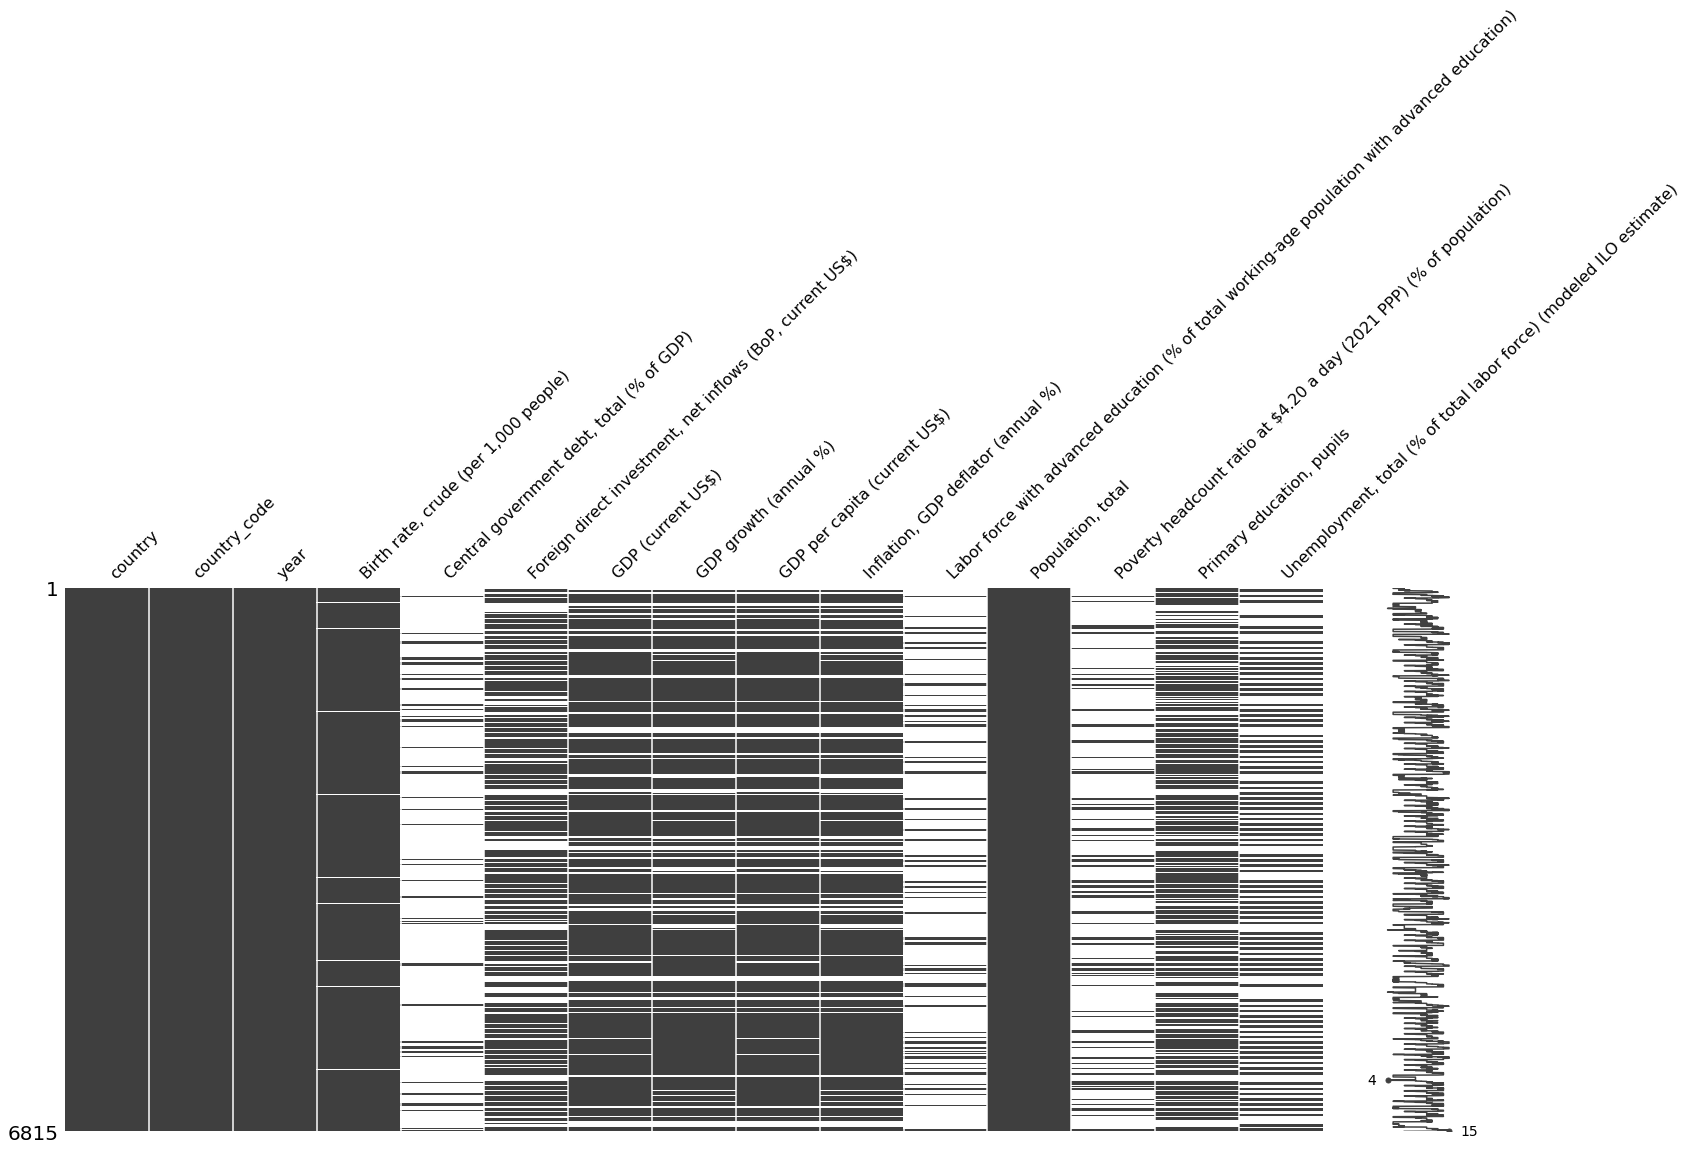

In [933]:
# Визуализируем пропуски в датасете 
msno.matrix(df_data_pivot)

In [934]:
# Выводим долю пропущенных строк в датафрейме
df_data_pivot.isna().mean()*100

indicator
country                                                                                             0.000000
country_code                                                                                        0.000000
year                                                                                                0.000000
Birth rate, crude (per 1,000 people)                                                                1.540719
Central government debt, total (% of GDP)                                                          89.464417
Foreign direct investment, net inflows (BoP, current US$)                                          31.034483
GDP (current US$)                                                                                  17.138665
GDP growth (annual %)                                                                              19.853265
GDP per capita (current US$)                                                                       17.138665
Inflation

### Данные заполнены неравномерно. Анализ показал, что ряд показателей заполнены менее, чем на 50%. Для дальнейшего анализа оставим показатели с заполненностью более 50%.

In [935]:
# Оставляем в датасете только те столбцы, которые имеют высокую долю заполнения
df_data_pivot=df_data_pivot[['country', 'country_code', 'year', 'Birth rate, crude (per 1,000 people)', 'Foreign direct investment, net inflows (BoP, current US$)', 
                            'GDP per capita (current US$)','Inflation, GDP deflator (annual %)','Primary education, pupils']]

In [936]:
#Изменяем названия столбцов
columns1= df_data_pivot.columns.tolist()
columns2 = ['country', 'country_code', 'year', 'birth_rate', 'foreign_investment', 
            'GDP_per_capita','inflation','primary_education']

change_dict1 = dict(zip(columns1, columns2))
df_data_pivot = df_data_pivot.rename(columns=change_dict1)
df_data_pivot

indicator,country,country_code,year,birth_rate,foreign_investment,GDP_per_capita,inflation,primary_education
0,Afghanistan,AFG,1960,50.52,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1961,50.57,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1962,50.67,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1963,50.79,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1964,50.85,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6810,"Korea, Rep.",KOR,2020,5.30,8.764900e+09,31721.30,1.56,2702647.0
6811,"Korea, Rep.",KOR,2021,5.10,2.206040e+10,35125.52,2.76,2681829.0
6812,"Korea, Rep.",KOR,2022,4.90,2.504470e+10,32394.68,1.28,2674487.0
6813,"Korea, Rep.",KOR,2023,4.50,1.904230e+10,33121.37,2.06,2614790.0


In [937]:
# Объединим дтафрейм со сводными данными по показателям и датафрейм с данными стран
df_data_pivot=df_data_pivot.merge(df_countries, how='left', left_on='country_code', right_on='id')

In [938]:
# Оставляем в датасете только те столбцы, которые необходимы для анализа
df_data_pivot=df_data_pivot[['country', 'country_code', 'year', 'birth_rate', 'foreign_investment',
       'GDP_per_capita', 'inflation', 'primary_education', 'region_id', 'region', 'income_level']]

In [939]:
# Выводим первые 5 строк
df_data_pivot.head()

,country,country_code,year,birth_rate,foreign_investment,GDP_per_capita,inflation,primary_education,region_id,region,income_level
0,Afghanistan,AFG,1960,50.52,NaN,NaN,NaN,NaN,MEA,"Middle East, North Africa, Afghanistan & Pakistan",Low income
1,Afghanistan,AFG,1961,50.57,NaN,NaN,NaN,NaN,MEA,"Middle East, North Africa, Afghanistan & Pakistan",Low income
2,Afghanistan,AFG,1962,50.67,NaN,NaN,NaN,NaN,MEA,"Middle East, North Africa, Afghanistan & Pakistan",Low income
3,Afghanistan,AFG,1963,50.79,NaN,NaN,NaN,NaN,MEA,"Middle East, North Africa, Afghanistan & Pakistan",Low income
4,Afghanistan,AFG,1964,50.85,NaN,NaN,NaN,NaN,MEA,"Middle East, North Africa, Afghanistan & Pakistan",Low income


In [940]:
# Выводим информацию о датафрейме
df_data_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6815 entries, 0 to 6814
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             6815 non-null   object 
 1   country_code        6815 non-null   object 
 2   year                6815 non-null   int64  
 3   birth_rate          6710 non-null   float64
 4   foreign_investment  4700 non-null   float64
 5   GDP_per_capita      5647 non-null   float64
 6   inflation           5462 non-null   float64
 7   primary_education   4375 non-null   float64
 8   region_id           6815 non-null   object 
 9   region              6815 non-null   object 
 10  income_level        6815 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 638.9+ KB


In [941]:
# Описательные статистики по всем странам
df_data_pivot.describe()

,year,birth_rate,foreign_investment,GDP_per_capita,inflation,primary_education
count,6815.000000,6710.000000,4.700000e+03,5647.000000,5462.000000,4.375000e+03
mean,1992.040352,26.758994,5.337467e+09,9432.454319,35.139914,4.479736e+06
std,18.746857,13.145587,2.121744e+10,16052.628192,495.624735,1.732523e+07
min,1960.000000,4.400000,-1.399723e+11,22.950000,-98.700000,1.623000e+03
25%,1976.000000,14.900000,1.231350e+07,645.105000,1.910000,1.120795e+05
50%,1992.000000,24.260000,1.541757e+08,2306.420000,4.870000,5.343090e+05
75%,2008.000000,38.910000,1.473926e+09,10202.460000,10.695000,2.127579e+06
max,2024.000000,55.380000,3.440750e+11,138934.960000,26765.860000,1.509410e+08


In [942]:
# Сгруппируем и сохраним в датафрейм показатели по годам и по уровню дохода
df_data_gr_inc=df_data_pivot.groupby(['income_level','year'])[['birth_rate', 'foreign_investment',
       'GDP_per_capita', 'inflation', 'primary_education']].mean().reset_index()
df_data_gr_inc

,income_level,year,birth_rate,foreign_investment,GDP_per_capita,inflation,primary_education
0,High income,1960,27.430233,NaN,1045.293810,NaN,NaN
1,High income,1961,27.033256,NaN,1120.244762,3.776667,NaN
2,High income,1962,26.682326,NaN,1166.722857,3.818636,NaN
3,High income,1963,26.550000,NaN,1255.059524,6.115455,NaN
4,High income,1964,26.249302,NaN,1388.376190,5.948182,NaN
...,...,...,...,...,...,...,...
320,Upper middle income,2020,16.241724,1.218909e+10,5887.646552,3.501724,7.342219e+06
321,Upper middle income,2021,15.845517,1.595159e+10,6673.684643,25.801379,7.063401e+06
322,Upper middle income,2022,15.480690,1.213846e+10,7584.610714,15.062759,7.079753e+06
323,Upper middle income,2023,15.193103,7.078991e+09,8002.975357,9.196207,7.797720e+06


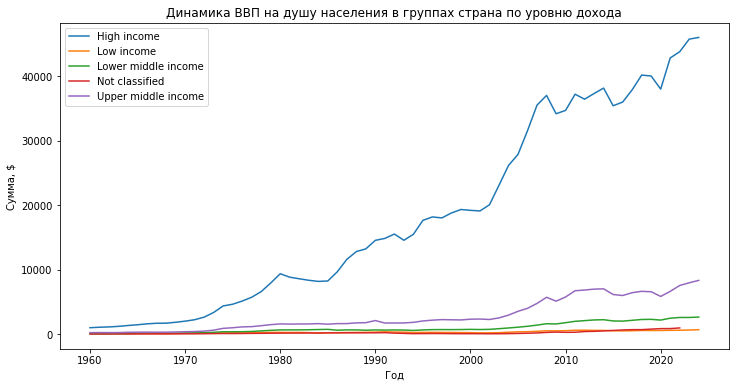

In [943]:
# Построим линейные графики для уровня ВВП на душу населения 
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_data_gr_inc, x='year', y='GDP_per_capita', hue='income_level')
plt.title('Динамика ВВП на душу населения в группах страна по уровню дохода')
plt.xlabel('Год')
plt.ylabel('Сумма, $')
plt.legend()
plt.show()  


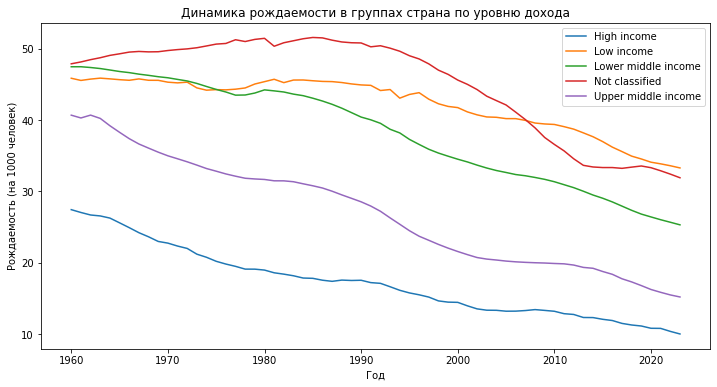

In [944]:
# Построим линейные графики для уровня рождаемости 
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_data_gr_inc, x='year', y='birth_rate', hue='income_level')
plt.title('Динамика рождаемости в группах страна по уровню дохода')
plt.xlabel('Год')
plt.ylabel('Рождаемость (на 1000 человек)')
plt.legend()
plt.show()  


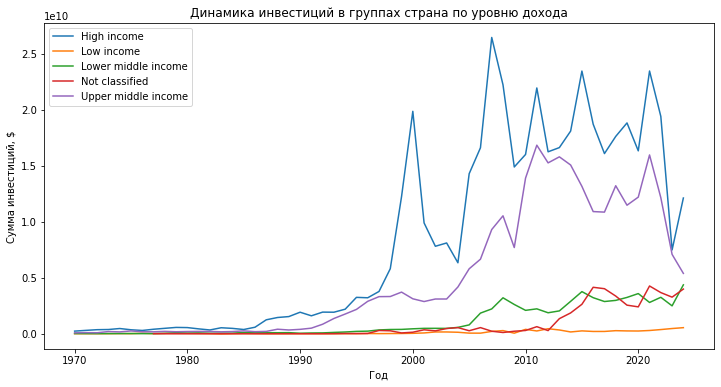

In [945]:
# Построим линейные графики для уровня инвестиций
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_data_gr_inc, x='year', y='foreign_investment', hue='income_level')
plt.title('Динамика инвестиций в группах страна по уровню дохода')
plt.xlabel('Год')
plt.ylabel('Сумма инвестиций, $')
plt.legend()
plt.show()  


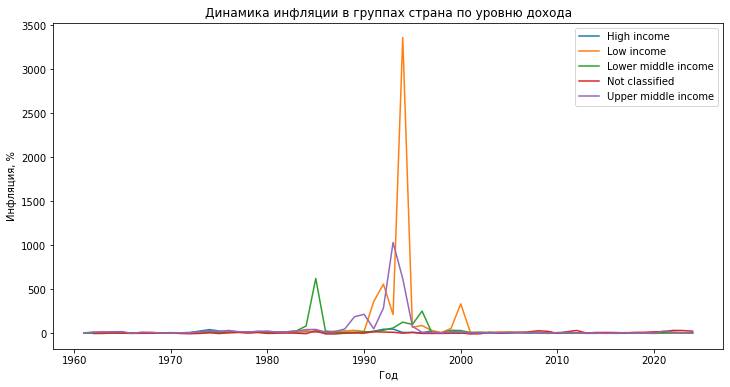

In [946]:
# Построим линейные графики для уровня инфляции
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_data_gr_inc, x='year', y='inflation', hue='income_level')
plt.title('Динамика инфляции в группах страна по уровню дохода')
plt.xlabel('Год')
plt.ylabel('Инфляция, %')
plt.legend()
plt.show()  


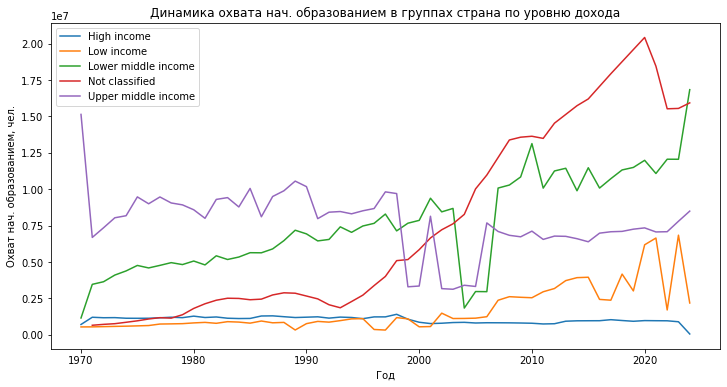

In [947]:
# Построим линейные графики для охвата нач. образованием 
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_data_gr_inc, x='year', y='primary_education', hue='income_level')
plt.title('Динамика охвата нач. образованием в группах страна по уровню дохода')
plt.xlabel('Год')
plt.ylabel('Охват нач. образованием, чел.')
plt.legend()
plt.show()  


In [948]:
# Вычисляем корреляционную матрицу 
correlation_matrix = df_data_gr_inc[['birth_rate', 'foreign_investment', 'GDP_per_capita', 'inflation', 
                                     'primary_education']].phik_matrix()

# Выводим результат
print('Корреляционная матрица для ВВП на душу населения')
correlation_matrix.loc[correlation_matrix.index != 'GDP_per_capita'][['GDP_per_capita']].sort_values(by='GDP_per_capita', ascending=False)

interval columns not set, guessing: ['birth_rate', 'foreign_investment', 'GDP_per_capita', 'inflation', 'primary_education']
Корреляционная матрица для ВВП на душу населения


,GDP_per_capita
birth_rate,0.86409
foreign_investment,0.85333
primary_education,0.39751
inflation,0.00000


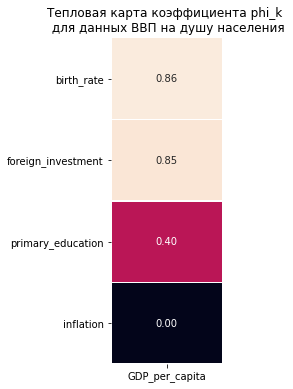

In [949]:
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции 
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'GDP_per_capita'][['GDP_per_capita']].sort_values(by='GDP_per_capita', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, 
            fmt='.2f', 
            cmap='rocket', 
            linewidths=0.5, 
            cbar=False)

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных ВВП на душу населения')


# Выводим график
plt.show()

### Анализ показывает, что наибольшую взаимосвязь с уровнем ВВП на душу населения имеют показатели уровня инвестиций и уровня рождаемости. Проанализируем распределение и взаимосвязь этих показателей в 1970, 1985, 2000, 2015 годах.

In [950]:
# Создадим новый столбец со значением инвестиций в миллионах
df_data_pivot['foreign_investment_mln']=round(df_data_pivot['foreign_investment']/1000000,0)

In [951]:
for i in [1970, 1985, 2000, 2015]:
    print(f'Основные описательные статистики показателей в {i} году')
    print(df_data_pivot[df_data_pivot['year']==i][['GDP_per_capita', 'birth_rate', 'foreign_investment_mln']].describe())
    print()

Основные описательные статистики показателей в 1970 году
       GDP_per_capita  birth_rate  foreign_investment_mln
count       73.000000  105.000000               57.000000
mean       999.180959   33.158762              113.614035
std       1117.348606   12.067979              285.818171
min         68.750000   13.400000               -1.000000
25%        206.770000   21.800000                5.000000
50%        408.600000   34.680000               26.000000
75%       1498.280000   44.120000               80.000000
max       4135.820000   52.680000             1827.000000

Основные описательные статистики показателей в 1985 году
       GDP_per_capita  birth_rate  foreign_investment_mln
count       85.000000  105.000000                80.00000
mean      3863.876000   29.395048               237.66250
std       5149.149689   13.075856               506.31873
min        161.120000   10.200000              -267.00000
25%        509.890000   16.740000                 0.75000
50%       1576.

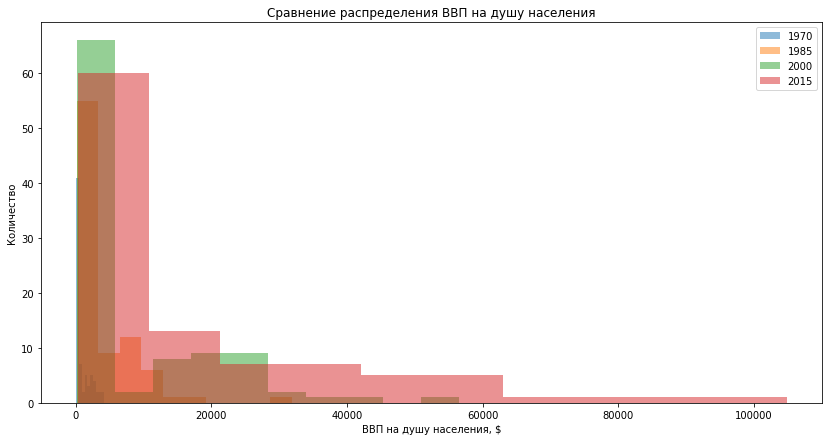

In [952]:
# Строим гистограммы распределения 
plt.figure(figsize=(14, 7))

for i in [1970, 1985, 2000, 2015]:
    df_data_pivot.loc[df_data_pivot['year'] == i, 'GDP_per_capita'].plot(
        kind='hist',
        bins=10,
        alpha=0.5,
        label=f'{i}',
        legend=True)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределения ВВП на душу населения')
plt.xlabel('ВВП на душу населения, $')
plt.ylabel('Количество')

plt.show()

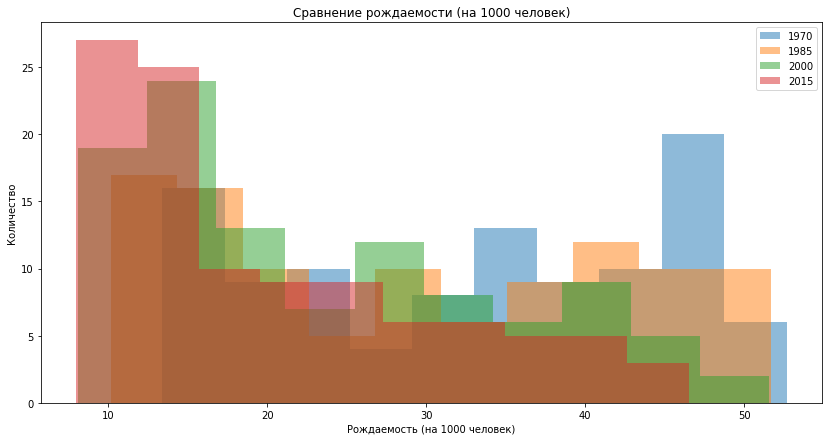

In [953]:
# Строим гистограммы распределения 
plt.figure(figsize=(14, 7))

for i in [1970, 1985, 2000, 2015]:
    df_data_pivot.loc[df_data_pivot['year'] == i, 'birth_rate'].plot(
        kind='hist',
        bins=10,
        alpha=0.5,
        label=f'{i}',
        legend=True)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение рождаемости (на 1000 человек)')
plt.xlabel('Рождаемость (на 1000 человек)')
plt.ylabel('Количество')

plt.show()

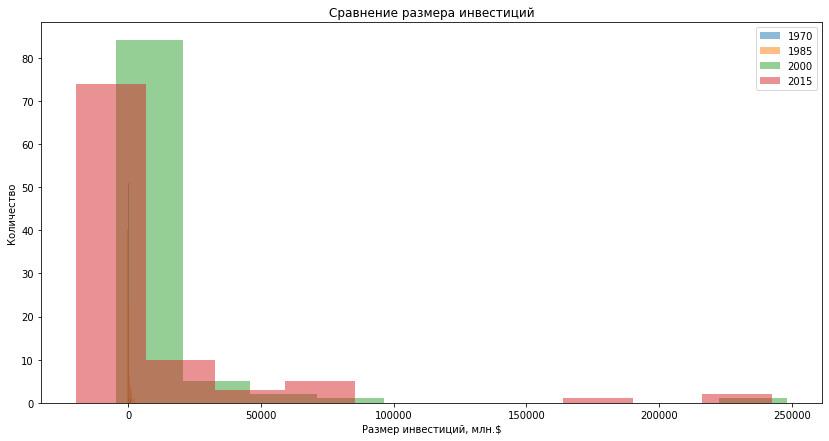

In [954]:
# Строим гистограммы распределения 
plt.figure(figsize=(14, 7))

for i in [1970, 1985, 2000, 2015]:
    df_data_pivot.loc[df_data_pivot['year'] == i, 'foreign_investment_mln'].plot(
        kind='hist',
        bins=10,
        alpha=0.5,
        label=f'{i}',
        legend=True)

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение размера инвестиций')
plt.xlabel('Размер инвестиций, млн.$')
plt.ylabel('Количество')

plt.show()

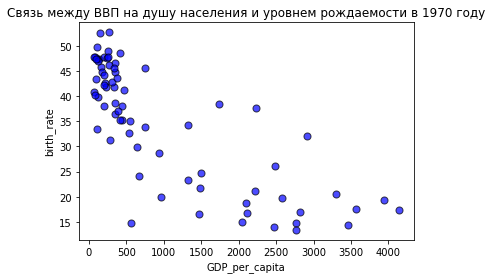

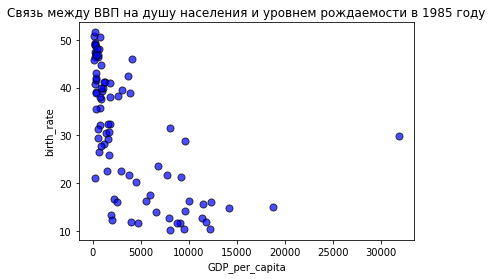

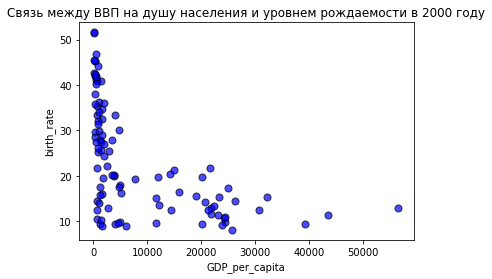

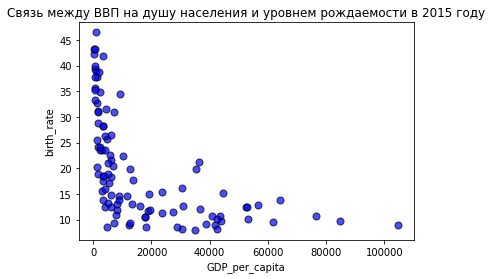

In [955]:
# Строим диаграмму рассеяния
for i in [1970, 1985, 2000, 2015]:
    df_data_pivot[df_data_pivot['year'] == i].plot(
        kind='scatter',       
    x='GDP_per_capita',  
    y='birth_rate', 
    alpha=0.7,           
    color='blue',        
    edgecolor='black',   
    s=50,                
    title=f'Связь между ВВП на душу населения и уровнем рождаемости в {i} году') 


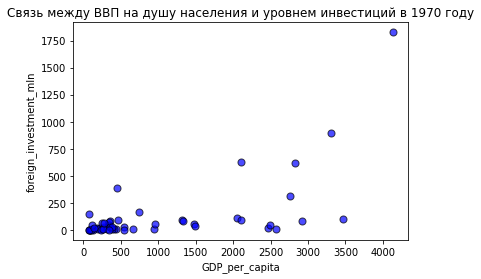

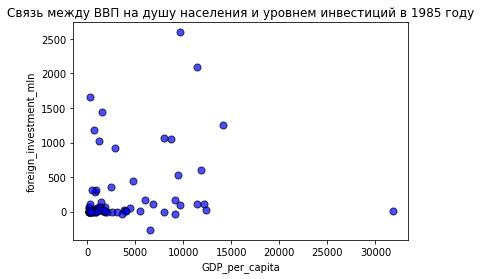

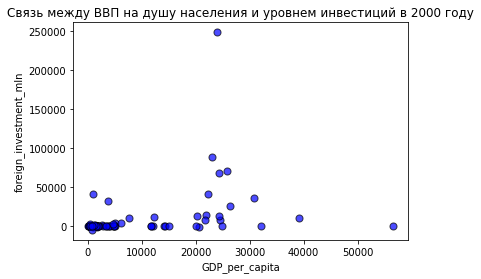

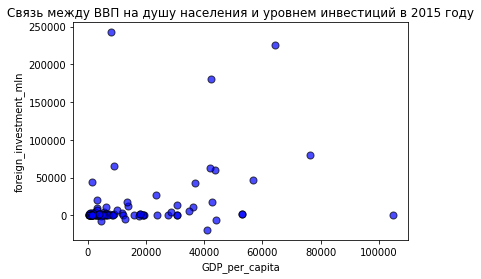

In [956]:
# Строим диаграмму рассеяния
for i in [1970, 1985, 2000, 2015]:
    df_data_pivot[df_data_pivot['year'] == i].plot(
        kind='scatter',       
    x='GDP_per_capita',  
    y='foreign_investment_mln', 
    alpha=0.7,           
    color='blue',        
    edgecolor='black',   
    s=50,                
    title=f'Связь между ВВП на душу населения и уровнем инвестиций в {i} году') 

### Вывод
Проведенные анализ позволяет сделать вывод, что уровень ВВП на душу населения имеет прямую зависимость от уровня прямых инстранных инвестиций и обратную зависитъмость от уровня рождаемости.